<a href="https://colab.research.google.com/github/jkcg-learning/HackerEarth_HolidaySeason/blob/main/HackerEarth_HolidaySeason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7164630381564470098, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16524070449043536161
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
from google.colab import files
files.upload()

Saving HolidaySeason.zip to HolidaySeason.zip


In [5]:
!unzip /content/HolidaySeason.zip  && rm /content/HolidaySeason.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/image1938.jpg  
  inflating: dataset/train/image7383.jpg  
  inflating: dataset/train/image5498.jpg  
  inflating: dataset/train/image6955.jpg  
  inflating: dataset/train/image4840.jpg  
  inflating: dataset/train/image2695.jpg  
  inflating: dataset/train/image524.jpg  
  inflating: dataset/train/image1074.jpg  
  inflating: dataset/train/image3524.jpg  
  inflating: dataset/train/image3570.jpg  
  inflating: dataset/train/image8561.jpg  
  inflating: dataset/train/image5242.jpg  
  inflating: dataset/train/image567.jpg  
  inflating: dataset/train/image8431.jpg  
  inflating: dataset/train/image529.jpg  
  inflating: dataset/train/image5156.jpg  
  inflating: dataset/train/image6005.jpg  
  inflating: dataset/train/image6678.jpg  
  inflating: dataset/train/image9808.jpg  
  inflating: dataset/train/image1214.jpg  
  inflating: dataset/train/image6836.jpg  
  inflating: dataset/train/image949.jpg  
  infla

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD,Adam,RMSprop,Nadam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

%load_ext tensorboard



#Helper libraries
import random
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import pandas as pd


print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.4.0
Num GPUs Available:  1
Number of accelerators:  1


In [30]:
# Defining the working directories
work_dir = '/content/dataset/'
os.listdir(work_dir) 
train_path = work_dir+'train/'

In [14]:
train_data = pd.read_csv(work_dir + 'train.csv')
train_data.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [15]:
total_nums = train_data.shape[0]
total_nums


6469

In [16]:
train_data.columns

Index(['Image', 'Class'], dtype='object')

In [17]:
print(train_data['Class'].value_counts())

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64


In [35]:
num_classes = len(train_data.Class.unique())
num_classes

6

In [22]:
Class_Labels = {'Miscellaneous':0,'Christmas_Tree':1,'Jacket':2,
                'Candle':3,'Airplane':4,'Snowman':5}

In [23]:
train_data['labels'] = train_data['Class'].apply(lambda x: Class_Labels[str(x)])
#visualize top 20 rows from table
train_data.head(20)

,Image,Class,labels
0,image3476.jpg,Miscellaneous,0
1,image5198.jpg,Candle,3
2,image4183.jpg,Snowman,5
3,image1806.jpg,Miscellaneous,0
4,image7831.jpg,Miscellaneous,0
5,image537.jpg,Airplane,4
6,image9774.jpg,Christmas_Tree,1
7,image5365.jpg,Airplane,4
8,image9367.jpg,Christmas_Tree,1
9,image4819.jpg,Christmas_Tree,1


In [27]:
train_data['labels']=train_data['labels'].astype(str)

In [36]:
count_category = train_data['labels'].value_counts()
count_category

0    2801
1    1539
2     640
3     593
4     535
5     361
Name: labels, dtype: int64

In [40]:
count_category[0]

2801

In [18]:
#importing necessary libraries
import cv2
IMG_SIZE = 300

In [68]:
train_datagen = ImageDataGenerator(#rescale = 1./255., # rescaling
                                   featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,
                                    samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=60,
                                    width_shift_range=0.3, height_shift_range=0.3, brightness_range=[0.1, 1.5], shear_range=30, zoom_range=[0.5, 1.5],
                                    channel_shift_range=90, fill_mode="nearest", cval=190, horizontal_flip=True, vertical_flip=True,
                                    rescale=1.0/255., preprocessing_function=None, data_format=None, validation_split=0.2, dtype=None)

val_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                 validation_split = 0.2)

train_generator = train_datagen.flow_from_dataframe(directory= train_path,
                                                    dataframe = train_data,
                                                    batch_size = 16,
                                                    x_col="Image",
                                                    y_col="labels",
                                                    subset="training",
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))

val_generator = val_datagen.flow_from_dataframe(directory = train_path,
                                                    dataframe = train_data,
                                                    batch_size = 16,
                                                    x_col="Image",
                                                    y_col="labels",
                                                    subset = "validation",
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode = 'categorical', 
                                                    target_size = (IMG_SIZE,IMG_SIZE))

Found 5176 validated image filenames belonging to 6 classes.
Found 1293 validated image filenames belonging to 6 classes.


In [69]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [70]:
class_weights_category = {}
i= 0


for key in train_generator.class_indices.keys():
    class_weights_category[i] = total_nums / (num_classes * count_category[key])
    i+=1

class_weights_category  

{0: 0.38492205164822085,
 1: 0.7005631362356508,
 2: 1.6846354166666666,
 3: 1.8181562675660483,
 4: 2.015264797507788,
 5: 2.986611265004617}

In [71]:
def plot_images(data_generator=None):
    plt.figure(figsize=(10, 10))
    if data_generator is not None:
        images,labels=data_generator.next()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            images[i,:,:,:]=images[i,:,:,:]*255.0
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[i,:,:,:].astype("uint8"))
            #plt.title(class_names[int(labels[i][0])])
            #plt.title(train_generator.class_indices.index(i))
            plt.title(np.argmax(labels[i]).astype(str))
            #plt.xlabel(train_data_modified.loc[train_data_modified['label'] == disease_title, 'disease_name'].item())
            
            #plt.axis("off")

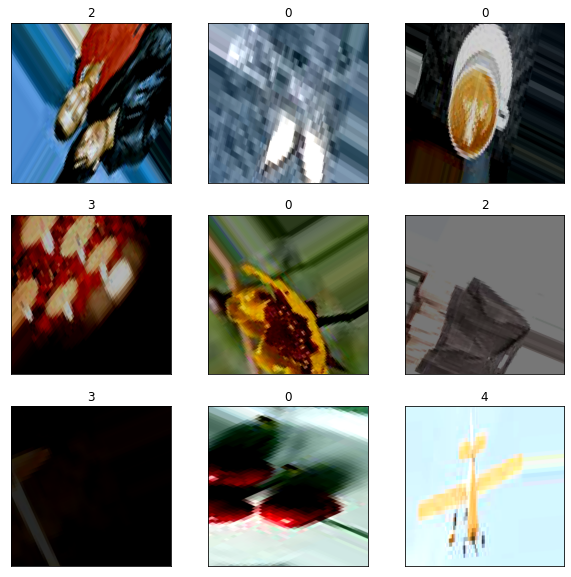

In [72]:
plot_images(train_generator)

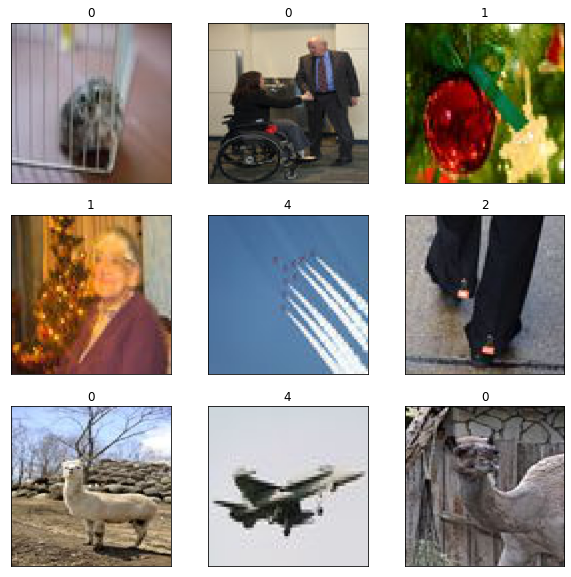

In [73]:
plot_images(val_generator)

In [83]:
# plotting helper function
def plotaccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [53]:
# plotting helper function
def plotloss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [74]:
# define input shape
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

model_layers = keras.applications.Xception(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

model_layers.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [75]:
# Fine-tune all the layers
for layer in model_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f80a65086d8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f80a6abd208> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f80a6a4c438> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f80a6511dd8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f80a6508940> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f80a87bda58> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f80a650bef0> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f80a6b33978> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f80a652ab00> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f80a7da6dd8> True
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f80a650be80> True
<tensorflow.python.keras.l

In [76]:
# define sequential model
model = Sequential()

# Add the efficientNet convolutional base model
model.add(model_layers)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))
#model_ResNet.add(Dense(35))
#SparseCategoricalCrossentropy(from_logits=True)
# compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

# view model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 20,819,246
Non-trainable params: 54,528
_________________________________________________________________


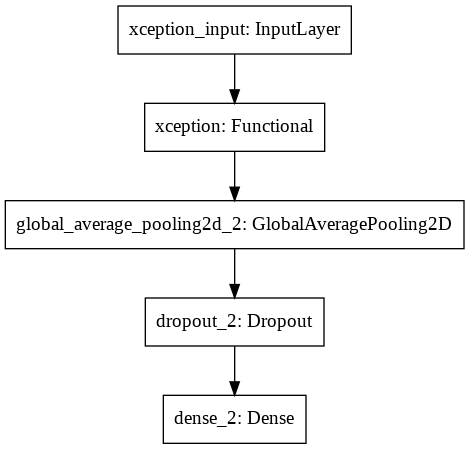

In [77]:
keras.utils.plot_model(model)

In [79]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    './best_weights.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    mode="min",
    min_delta=0.001,
)

In [80]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(train_generator,
                    validation_data = val_generator,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=(len(train_data)*0.8) // BATCH_SIZE,
                    validation_steps=(len(train_data)*0.2) // BATCH_SIZE,
                    callbacks = [model_checkpoint, es_callback, reduce_lr], 
                    epochs=EPOCHS,
                    #class_weight = class_weights_category,
                    verbose=1)

Epoch 1/50
323/323 [==============================] - 205s 623ms/step - loss: 1.2907 - accuracy: 0.5299 - val_loss: 1.8088 - val_accuracy: 0.5117

Epoch 00001: val_loss improved from inf to 1.80880, saving model to ./best_weights.h5
Epoch 2/50
323/323 [==============================] - 205s 633ms/step - loss: 1.0650 - accuracy: 0.5959 - val_loss: 1.2016 - val_accuracy: 0.5953

Epoch 00002: val_loss improved from 1.80880 to 1.20155, saving model to ./best_weights.h5
Epoch 3/50
323/323 [==============================] - 210s 650ms/step - loss: 1.0150 - accuracy: 0.6167 - val_loss: 0.9325 - val_accuracy: 0.6883

Epoch 00003: val_loss improved from 1.20155 to 0.93249, saving model to ./best_weights.h5
Epoch 4/50
323/323 [==============================] - 210s 649ms/step - loss: 0.9360 - accuracy: 0.6479 - val_loss: 0.9508 - val_accuracy: 0.7109

Epoch 00004: val_loss did not improve from 0.93249
Epoch 5/50
323/323 [==============================] - 208s 643ms/step - loss: 0.9112 - accuracy

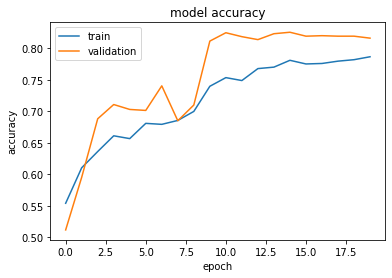

In [84]:
plotaccuracy(history)

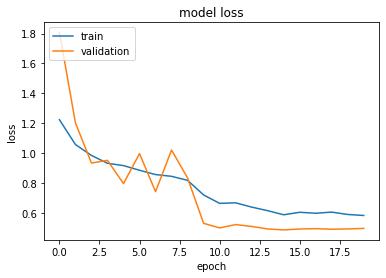

In [85]:
plotloss(history)

In [130]:
test_imgs_folder = '/content/dataset/test/'

files_in_test = sorted(os.listdir(test_imgs_folder))

images=[i for i in files_in_test]

test_dataset = pd.DataFrame()
test_dataset['Image']=[str(x) for x in images]
print(test_dataset.head(10))

           Image
0    image10.jpg
1   image100.jpg
2  image1013.jpg
3  image1014.jpg
4  image1018.jpg
5  image1019.jpg
6  image1021.jpg
7  image1023.jpg
8  image1024.jpg
9  image1029.jpg


In [131]:
test_dataset.shape

(3489, 1)

In [171]:
prediction = [] 
results = []

In [173]:



for image in test_dataset.Image:
    img = keras.preprocessing.image.load_img(test_imgs_folder + image)
    img = keras.preprocessing.image.img_to_array(img)
    img = keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    #img = np.divide(img, 255.0)
    img = np.expand_dims(img, 0) 
    
    preds = model.predict(img)
    #print(prediction)
    prediction.append(np.argmax(preds))
    #print(prediction)
    #print(preds)
    #res = max(set(preds))
    #results.append(res)
    #print(results)



In [135]:
len(prediction)

3489

In [145]:
len(results)

3489

In [159]:
my_submission = pd.DataFrame({'Image': test_dataset.Image, 'Result': results})
my_submission.to_csv('submission_act.csv', index=False) 

In [160]:
my_submission

,Image,Result
0,image10.jpg,2
1,image100.jpg,2
2,image1013.jpg,2
3,image1014.jpg,2
4,image1018.jpg,2
...,...,...
3484,image9953.jpg,2
3485,image9956.jpg,2
3486,image9958.jpg,2
3487,image9960.jpg,3


In [164]:
Labels_Class = {0:'Miscellaneous',1:'Christmas_Tree',2:'Jacket',
                3:'Candle',4:'Airplane',5:'Snowman'}

In [165]:
my_submission['Class'] = my_submission['Result'].apply(lambda x: Labels_Class[x])
#visualize top 20 rows from table
#

In [166]:
my_submission

,Image,Result,Class
0,image10.jpg,2,Jacket
1,image100.jpg,2,Jacket
2,image1013.jpg,2,Jacket
3,image1014.jpg,2,Jacket
4,image1018.jpg,2,Jacket
...,...,...,...
3484,image9953.jpg,2,Jacket
3485,image9956.jpg,2,Jacket
3486,image9958.jpg,2,Jacket
3487,image9960.jpg,3,Candle
